In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
import keras
# from keras import optimizers, Sequential
# from keras.models import Model
# from keras.utils.vis_utils import plot_model
# from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
# from keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(11)

from sklearn.model_selection import train_test_split

SEED = 123
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [26]:
import os
import csv

# lab pc file dir
# path_1 = "C:/Users/sue33/Desktop/pjuns/DB/EM/Training/vibration/vibration/2.2kW/L-DEF-01/정상/"
# path_2 = "C:/Users/sue33/Desktop/pjuns/DB/EM/Training/vibration/vibration/2.2kW/L-DSF-01/축정렬불량/"

# home pc file dir
path_1 = "G:/VSC/MLD/DB/정상/"
path_2 = "G:/VSC/MLD/DB/축정렬불량/"

# number of test files(for each labels)
file_num = 20

file_list_1 = os.listdir(path_1)[:file_num]
file_list_2 = os.listdir(path_2)[:file_num]
file_list = file_list_1 + file_list_2
file_list = file_list_1

In [27]:
# 파일로 부터 원하는 정보 추출

raw_data = []

for i, file_name in enumerate(file_list):
    if i < file_num:
        f = open(path_1+file_name, 'r', encoding='utf-8')
    else:
        f = open(path_2+file_name, 'r', encoding='utf-8')

    # rdr : file to list
    rdr = list(csv.reader(f))

    label = int(rdr[3][1]) # y
    value = np.array(list(rdr[9:]))[:, 1:2] # X

    f.close()

    data = [value, label]
    raw_data.append(data)


In [28]:
# 정보로 부터 학습에 사용할 벡터 생성

column_name = ['y', 'x']
temporalize_df = []

for d in raw_data:
    if d[1] == 0:
        temp = np.concatenate((np.zeros((12000, 1)), d[0]), axis=1)
    else:
        temp = np.concatenate((np.ones((12000, 1)), d[0]), axis=1)
        
    temporalize_df.append(pd.DataFrame(temp, columns=column_name).astype(np.float32))

In [29]:
# 시계열 데이터를 원하는 크기로 조각냄

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(0, len(X)-lookback-1, lookback//2):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [30]:
# 8개를 한 주기로 조각냄
# 12000개의 시계열 데이터에서 최대 12000 - 7 개의 조각이 나오지만
# 데이터가 너무 많아지면 학습에 사용할 컴퓨터의 성능 제약 때문에
# 주기의 절반만큼 건너뛰게 하여 (12000//4)-(8//2) = 2998 개의 조각이 나오도록 함.

n_features = 1
lookback = 8

X = []
y = []

for d in temporalize_df:
    input_X = d.loc[:, d.columns != 'y'].values
    input_y = d['y'].values

    nX, ny = temporalize(X = input_X, y = input_y, lookback = lookback)
    X.extend(nX)
    y.extend(ny)

In [31]:
X = np.array(X)
X_test = X.reshape(X.shape[0], lookback, n_features)
y_test = np.array(y)

In [32]:
# 학습에 사용하기 위해 원하는 모양으로 가공
# 학습의 효율 증대를 위해 scaler 사용

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [33]:
scaler = StandardScaler().fit(flatten(X))

In [34]:
X_test_scaled = scale(X_test, scaler).astype(np.float32)

In [35]:
timesteps =  X_test_scaled.shape[1] # equal to the lookback
n_features =  X_test_scaled.shape[2] # 59

In [36]:
# import joblib

In [37]:
# 학습된 모델 불러옴

lstm_autoencoder = keras.models.load_model("1123_model.h5")

1874/1874 [==============================] - 25s 13ms/step


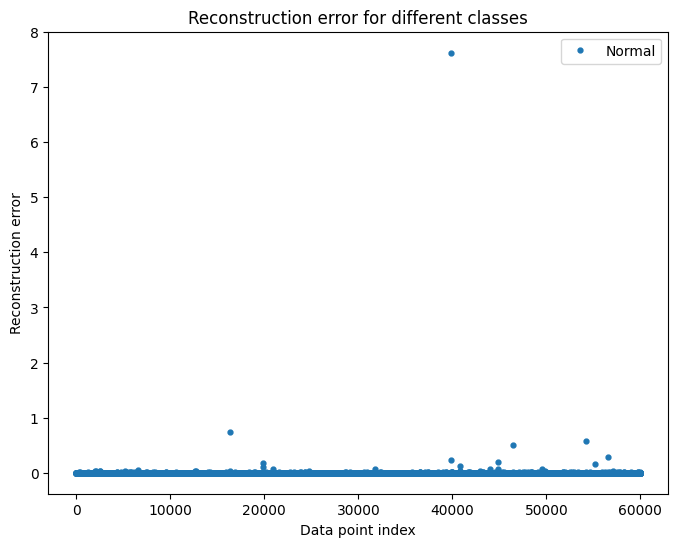

In [38]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [39]:
# import pickle
 
# ## pickle은 python에 특화된 binary 파일
# # 예측값 저장
# with open("pred_1129_1000.pickle","wb") as f:
#     pickle.dump(test_x_predictions, f)
# # 예측값 mse 저장
# with open("mse_1129_1000.pickle","wb") as f:
#     pickle.dump(mse, f)
    
# # 불러오는 방법
# # with open("pred_1129_1000.pickle","rb") as fi:
# #     test_x_predictions = pickle.load(fi)
# # with open("mse_1129_1000.pickle","rb") as fi:
# #     mse = pickle.load(fi)
 
# # 불러온 test의 type과 값 출력
# # print(type(test))
# # print(test)


In [40]:
# Auto Encoder의 Pred로부터 고장 예측

data_len = 2998
percent005 = data_len//200 + 1
new_Pred_y = [0 for i in range(1000)]
True_y = [0 if i < 500 else 1 for i in range(1000)]

threshold_fixed = 0.05

for file_num in range(1000):
    start = file_num * data_len
    end = start + data_len + 1

    part = mse[start:end]
    
    part.sort()
    part = part[::-1]
    part = part[:percent005]

    if np.average(part) > threshold_fixed:
        new_Pred_y[file_num] = 1

g:\anaconda3\envs\MLD\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
g:\anaconda3\envs\MLD\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
# 성능 Test

FalsePos = 0
TruePos = 0

FalseNeg = 0
TrueNeg = 0

for i in range(len(new_Pred_y)):
    if new_Pred_y[i] == 1:
        if True_y[i] == 1:
            TruePos += 1
        else:
            FalsePos += 1
    else:
        if True_y[i] == 1:
            FalseNeg += 1
        else:
            TrueNeg += 1

print("TruePos", TruePos)
print("FalsePos", FalsePos)

print("FalseNeg", FalseNeg)
print("TrueNeg", TrueNeg)

TruePos 0
FalsePos 15
FalseNeg 500
TrueNeg 485
